In [1]:
!conda install -y gdown -q

Retrieving notices: ...working... done
done
Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.13.1            |     pyhd8ed1ab_0          15 KB  conda-forge
    gdown-5.1.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    openssl-3.2.1              |       hd590300_1         2.7 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.8 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.13.1-pyhd8ed1ab_0 
  gdown              conda-forge/noarch::gdown-5.1.0-pyhd8ed1ab_0 

The following packages will be UPDATED:

  openssl                                  3.2.1-hd590300_0 --> 3.2.1-hd590300_1 




In [16]:
!gdown --id 17eQw768YlcJ5a1qMVuolSusBEbB51c2g
!unzip -qq prep.zip

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=17eQw768YlcJ5a1qMVuolSusBEbB51c2g
From (redirected): https://drive.google.com/uc?id=17eQw768YlcJ5a1qMVuolSusBEbB51c2g&confirm=t&uuid=0e6fa67a-7818-4a11-97f8-296ab2a89096
To: /kaggle/working/prep.zip
100%|██████████████████████████████████████| 39.2M/39.2M [00:00<00:00, 42.9MB/s]


In [3]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [30]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*18*18, 128)
        self.fc2 = nn.Linear(128, 3)

        self.relu = nn.LeakyReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, image: torch.Tensor) -> torch.Tensor:
        image = self.pool(self.relu(self.bn1(self.conv1(image))))
        image = self.pool(self.relu(self.bn2(self.conv2(image))))
        image = self.pool(self.relu(self.bn3(self.conv3(image))))
        image = image.view(-1, 64*18*18)
        image = self.dropout(self.relu(self.fc1(image)))
        image = self.fc2(image)
        return image

In [31]:
def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample

train_path = 'preprocessed/train' # 'dataset/train'
val_path = 'preprocessed/val' # 'dataset/val'
batch_size = 128
learning_rate = 1e-4
weight_decay = 1e-5
num_epochs = 60
transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])
# train_data = datasets.DatasetFolder(root=train_path, loader=npy_loader, extensions='.npy') # , transform=transform
train_data = datasets.ImageFolder(train_path, transform=transform)
print('Training Classes: ' + str(train_data.class_to_idx))
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
# val_data = datasets.DatasetFolder(root=val_path, loader=npy_loader, extensions='.npy')
val_data = datasets.ImageFolder(train_path, transform=transform)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)

Training Classes: {'0': 0, '1': 1, '2': 2}


In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [41]:
model.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    for data, target in tqdm(trainloader):
        data = data.to(device).float()
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(trainloader.dataset)
    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f}')

100%|██████████| 235/235 [00:13<00:00, 17.12it/s]


Epoch: 1 	Training Loss: 0.260025


100%|██████████| 235/235 [00:13<00:00, 16.80it/s]


Epoch: 2 	Training Loss: 0.248293


100%|██████████| 235/235 [00:13<00:00, 17.34it/s]


Epoch: 3 	Training Loss: 0.234330


100%|██████████| 235/235 [00:13<00:00, 16.83it/s]


Epoch: 4 	Training Loss: 0.223145


100%|██████████| 235/235 [00:14<00:00, 16.35it/s]


Epoch: 5 	Training Loss: 0.206383


100%|██████████| 235/235 [00:13<00:00, 17.00it/s]


Epoch: 6 	Training Loss: 0.196548


100%|██████████| 235/235 [00:13<00:00, 17.40it/s]


Epoch: 7 	Training Loss: 0.183696


100%|██████████| 235/235 [00:13<00:00, 16.90it/s]


Epoch: 8 	Training Loss: 0.173917


100%|██████████| 235/235 [00:13<00:00, 17.22it/s]


Epoch: 9 	Training Loss: 0.167614


100%|██████████| 235/235 [00:13<00:00, 17.05it/s]


Epoch: 10 	Training Loss: 0.159207


100%|██████████| 235/235 [00:13<00:00, 16.90it/s]


Epoch: 11 	Training Loss: 0.150962


100%|██████████| 235/235 [00:13<00:00, 17.31it/s]


Epoch: 12 	Training Loss: 0.146435


100%|██████████| 235/235 [00:14<00:00, 16.69it/s]


Epoch: 13 	Training Loss: 0.134571


100%|██████████| 235/235 [00:13<00:00, 17.29it/s]


Epoch: 14 	Training Loss: 0.133138


100%|██████████| 235/235 [00:13<00:00, 17.02it/s]


Epoch: 15 	Training Loss: 0.130735


100%|██████████| 235/235 [00:13<00:00, 17.18it/s]


Epoch: 16 	Training Loss: 0.128423


100%|██████████| 235/235 [00:13<00:00, 17.45it/s]


Epoch: 17 	Training Loss: 0.110441


100%|██████████| 235/235 [00:13<00:00, 16.80it/s]


Epoch: 18 	Training Loss: 0.115022


100%|██████████| 235/235 [00:13<00:00, 17.37it/s]


Epoch: 19 	Training Loss: 0.104089


100%|██████████| 235/235 [00:13<00:00, 16.81it/s]


Epoch: 20 	Training Loss: 0.096791


100%|██████████| 235/235 [00:13<00:00, 17.22it/s]


Epoch: 21 	Training Loss: 0.094563


100%|██████████| 235/235 [00:13<00:00, 17.19it/s]


Epoch: 22 	Training Loss: 0.093767


100%|██████████| 235/235 [00:13<00:00, 17.23it/s]


Epoch: 23 	Training Loss: 0.093730


100%|██████████| 235/235 [00:14<00:00, 16.48it/s]


Epoch: 24 	Training Loss: 0.087059


100%|██████████| 235/235 [00:13<00:00, 16.88it/s]


Epoch: 25 	Training Loss: 0.086921


100%|██████████| 235/235 [00:13<00:00, 17.29it/s]


Epoch: 26 	Training Loss: 0.080623


100%|██████████| 235/235 [00:14<00:00, 16.77it/s]


Epoch: 27 	Training Loss: 0.084060


100%|██████████| 235/235 [00:13<00:00, 17.31it/s]


Epoch: 28 	Training Loss: 0.077448


100%|██████████| 235/235 [00:13<00:00, 17.02it/s]


Epoch: 29 	Training Loss: 0.080603


100%|██████████| 235/235 [00:13<00:00, 16.81it/s]


Epoch: 30 	Training Loss: 0.077143


100%|██████████| 235/235 [00:13<00:00, 17.33it/s]


Epoch: 31 	Training Loss: 0.071403


100%|██████████| 235/235 [00:13<00:00, 16.99it/s]


Epoch: 32 	Training Loss: 0.064175


100%|██████████| 235/235 [00:13<00:00, 17.43it/s]


Epoch: 33 	Training Loss: 0.074420


100%|██████████| 235/235 [00:13<00:00, 16.79it/s]


Epoch: 34 	Training Loss: 0.075143


100%|██████████| 235/235 [00:13<00:00, 17.37it/s]


Epoch: 35 	Training Loss: 0.061238


100%|██████████| 235/235 [00:13<00:00, 17.09it/s]


Epoch: 36 	Training Loss: 0.062999


100%|██████████| 235/235 [00:13<00:00, 17.15it/s]


Epoch: 37 	Training Loss: 0.060081


100%|██████████| 235/235 [00:13<00:00, 16.88it/s]


Epoch: 38 	Training Loss: 0.060314


100%|██████████| 235/235 [00:14<00:00, 16.78it/s]


Epoch: 39 	Training Loss: 0.062386


100%|██████████| 235/235 [00:13<00:00, 17.36it/s]


Epoch: 40 	Training Loss: 0.054681


100%|██████████| 235/235 [00:13<00:00, 16.96it/s]


Epoch: 41 	Training Loss: 0.062132


100%|██████████| 235/235 [00:13<00:00, 17.28it/s]


Epoch: 42 	Training Loss: 0.063777


100%|██████████| 235/235 [00:13<00:00, 17.13it/s]


Epoch: 43 	Training Loss: 0.055237


100%|██████████| 235/235 [00:13<00:00, 17.23it/s]


Epoch: 44 	Training Loss: 0.055969


100%|██████████| 235/235 [00:13<00:00, 17.40it/s]


Epoch: 45 	Training Loss: 0.053333


100%|██████████| 235/235 [00:13<00:00, 16.93it/s]


Epoch: 46 	Training Loss: 0.053302


100%|██████████| 235/235 [00:13<00:00, 17.27it/s]


Epoch: 47 	Training Loss: 0.058873


100%|██████████| 235/235 [00:13<00:00, 16.84it/s]


Epoch: 48 	Training Loss: 0.055412


100%|██████████| 235/235 [00:13<00:00, 17.36it/s]


Epoch: 49 	Training Loss: 0.056136


100%|██████████| 235/235 [00:13<00:00, 16.90it/s]


Epoch: 50 	Training Loss: 0.055606


100%|██████████| 235/235 [00:13<00:00, 17.04it/s]


Epoch: 51 	Training Loss: 0.044521


100%|██████████| 235/235 [00:13<00:00, 17.35it/s]


Epoch: 52 	Training Loss: 0.047140


100%|██████████| 235/235 [00:13<00:00, 16.86it/s]


Epoch: 53 	Training Loss: 0.048471


100%|██████████| 235/235 [00:13<00:00, 17.39it/s]


Epoch: 54 	Training Loss: 0.048426


100%|██████████| 235/235 [00:13<00:00, 16.86it/s]


Epoch: 55 	Training Loss: 0.049661


100%|██████████| 235/235 [00:13<00:00, 17.17it/s]


Epoch: 56 	Training Loss: 0.049979


100%|██████████| 235/235 [00:13<00:00, 17.38it/s]


Epoch: 57 	Training Loss: 0.046067


100%|██████████| 235/235 [00:14<00:00, 16.48it/s]


Epoch: 58 	Training Loss: 0.041911


100%|██████████| 235/235 [00:13<00:00, 17.27it/s]


Epoch: 59 	Training Loss: 0.046020


100%|██████████| 235/235 [00:14<00:00, 16.20it/s]

Epoch: 60 	Training Loss: 0.041994


In [42]:
y_test, predictions = [], []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(valloader):
        images = images.to(device).float()
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_test.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())
    acc = 100 * correct / total
    print(
        f'Accuracy of the network on the {total} test images:'
        f'{acc:.3f} %'
    )

100%|██████████| 235/235 [00:11<00:00, 20.02it/s]

Accuracy of the network on the 30000 test images:98.403 %


In [48]:
torch.save(model.state_dict(), "my_cnn_acc_98.4.pth")

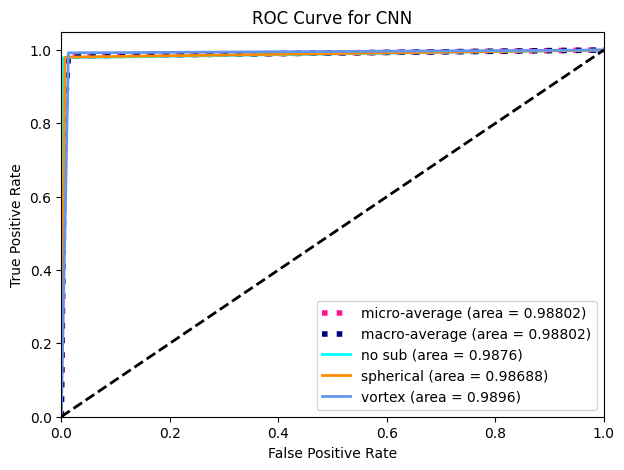

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

n_classes = 3

pred = label_binarize(predictions, classes=[0,1,2])
y = label_binarize(y_test, classes=[0,1,2])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.rcParams['figure.figsize'] = [7, 5]
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {})'
               ''.format(round(roc_auc["micro"],5)),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {})'
               ''.format(round(roc_auc["macro"],5)),
         color='navy', linestyle=':', linewidth=4)

labels = ['no sub', 'spherical', 'vortex']
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{} (area = {})'
             ''.format(labels[i], round(roc_auc[i],5)))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN')
plt.legend(loc="lower right", prop={"size":10})
None

In [46]:
plt.savefig('roc-auc.png', dpi=500)

<Figure size 700x500 with 0 Axes>